In [1]:
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
import tensorflow as tf 

tokenizer = SimpleTokenizer()
MAX_PROMPT_LENGTH = 77
def generate_tokens(tokenizer, prompt, MAX_PROMPT_LENGTH):

  inputs = tokenizer.encode(prompt)
  if len(inputs) > MAX_PROMPT_LENGTH:
      raise ValueError(
          f"Prompt is too long (should be <= {MAX_PROMPT_LENGTH} tokens)"
      )
  phrase = tf.concat([inputs, ([49407] * (MAX_PROMPT_LENGTH - len(inputs)))], axis=0)

  return phrase

tokens = generate_tokens(tokenizer, "a ferrari car with wings", MAX_PROMPT_LENGTH)
print(tokens)

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.
tf.Tensor(
[49406   320  9606  1615   593  5178 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
 49407 49407 49407 49407 49407], shape=(77,), dtype=int32)


In [7]:
stable_diffusion_service_ip = input("Please enter the service IP address of the cluster: ")
print(f"Setting the IP address to: {stable_diffusion_service_ip}")

Please enter the service IP address of the cluster34.27.239.68
Setting the IP address to: 34.27.239.68


In [9]:
import requests
import json
import numpy as np
import time

tokens_list = [
    generate_tokens(tokenizer, "A wine glass made from lego bricks, rainbow colored liquid being poured into it, hyper realistic, high detail", MAX_PROMPT_LENGTH).numpy().tolist(),
    generate_tokens(tokenizer, "A staircase made from color pencils, hyper realistic, high detail", MAX_PROMPT_LENGTH).numpy().tolist(),
    generate_tokens(tokenizer, "A ferrari car in the space astronaut driving it, futuristic, hyper realistic, high detail", MAX_PROMPT_LENGTH).numpy().tolist(),
    generate_tokens(tokenizer, "a dragon covered with weapons fighting an army, fire, explosions, hyper realistic, high detail", MAX_PROMPT_LENGTH).numpy().tolist(),
    generate_tokens(tokenizer, "A sawing girl in a boat, hyper realistic, high detail", MAX_PROMPT_LENGTH).numpy().tolist(),
    
]
negative_tokens = generate_tokens(tokenizer, "low quality, ugly, bad anatomy, unnatural, strange, unrealistic", MAX_PROMPT_LENGTH).numpy().tolist()

def generate_json_data(tokens, negative_tokens):
    data = json.dumps(
        {
            "signature_name": "serving_default", 
            "instances": [
                {
                    "tokens": tokens,
                    "negative_prompt_tokens": negative_tokens,
                    "num_steps": 30,
                    "batch_size": 1,
                }
            ]
         }
    )
    
    return data

url = f"http://{stable_diffusion_service_ip}:8501/v1/models/stable-diffusion:predict"

def predict_rest(json_data, url):
    json_response = requests.post(url, data=json_data)
    response = json.loads(json_response.text)
    if "predictions" not in response:
      print(response)
    rest_outputs = np.array(response["predictions"])
    return rest_outputs

# Takes about 215s to generate one image
all_images = []
all_data = []
for tokens, negative_tokens in zip(tokens_list, [negative_tokens for _ in range(5)]):
    all_data.append(generate_json_data(tokens, negative_tokens))

all_images = [predict_rest(data, url) for data in all_data]


5
1
2
3
3
4


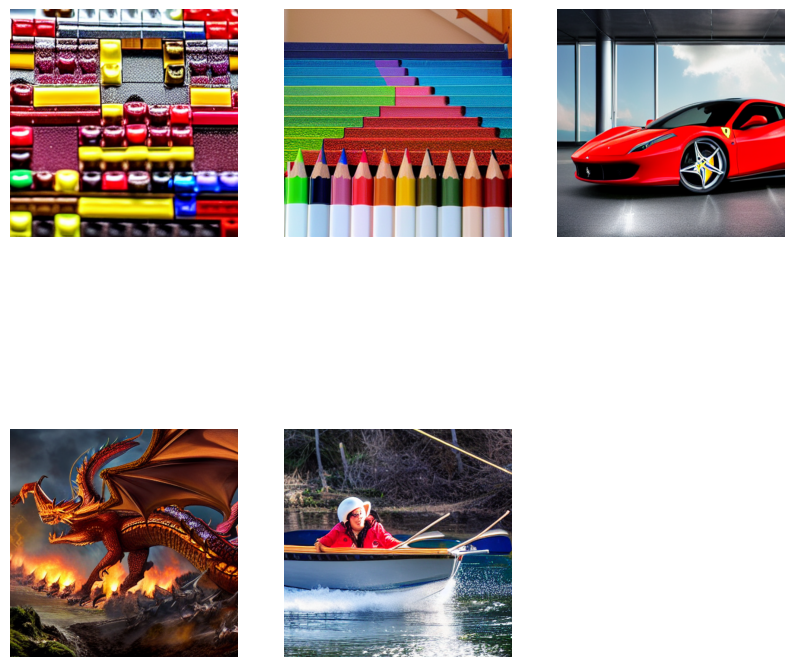

In [18]:
import matplotlib.pyplot as plt

n_cols = 3
def plot_images(all_images, n_rows, n_cols):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(all_images):
        ax = plt.subplot(n_rows, n_cols, (i//n_cols)*n_cols + (i%n_cols) + 1)
        plt.imshow(image[0])
        plt.axis("off")


n_rows = (len(all_images)//n_cols)+int(len(all_images)%n_cols!=0)
plot_images(all_images, n_rows, n_cols)